In [ ]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from scipy import stats

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)  

# Some styling
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

import plotly.io as pio
pio.renderers.default = 'colab'
pio.templates.default = 'ggplot2'
%matplotlib inline

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
raw_data_link = 'https://raw.githubusercontent.com/elvanselvano/purwadhika-final-project/main/dataset/DC_Properties.csv'
df = pd.read_csv(raw_data_link, index_col=0)

### 1. CASTING

In [ ]:
df['NUM_UNITS'] = df['NUM_UNITS'].astype(pd.Int64Dtype())
df['KITCHENS'] = df['KITCHENS'].astype(pd.Int64Dtype())
df['USECODE'] = df['USECODE'].astype(pd.Int64Dtype()).astype('category')
df['ZIPCODE'] = df['ZIPCODE'].astype(pd.Int64Dtype()).astype('category')
df['CMPLX_NUM'] = df['CMPLX_NUM'].astype(pd.Int64Dtype())
df['CENSUS_TRACT'] = df['CMPLX_NUM'].astype(pd.Int64Dtype())
df['SALEDATE'] = pd.to_datetime(df['SALEDATE'])

### 2. QUALIFIED FEATURES 

The QUALIFIED feature is internally-used indicator to reflect if a sale is representative of market value according to the office's internal criteria. Since the 'U' means it does not reflect the market value, we will drop the 'U' value and QUALIFIED feature since it only contains 1 value of 'Q'.

In [ ]:
df_q = df[df['QUALIFIED']=='Q']
df_q = df_q.drop('QUALIFIED', axis=1)

In [ ]:
print('Before removing unqualified:', df.shape)
print('After removing unqualified:', df_q.shape)

Before removing unqualified: (158957, 48)
After removing unqualified: (76349, 47)


### 3. PRICE AND SALEDATE

Since we have no feature that affects the trend, such as inflation, we decide to take more recent price data (2010 onwards)

In [ ]:
df_q['SALEYEAR'] = df_q['SALEDATE'].dt.year

In [ ]:
df_2010 = df_q[df_q['SALEYEAR']>=2010]
df_2010 = df_2010.drop('SALEDATE',axis=1)

- Drop outliers data



In [ ]:
q1 = df_2010['PRICE'].quantile(0.25)
q3 = df_2010['PRICE'].quantile(0.75)

iqr = q3-q1
low_whisker = q1 - 1.5*iqr
upp_whisker = q3 + 1.5*iqr

print(low_whisker)
print(upp_whisker)

-271500.0
1412500.0


In [ ]:
df_2010_1 = df_2010[df_2010['PRICE']< upp_whisker] #remove outlier

By analizing the shape of the dataframe, we can see that there are 2514 outliers in the price column. 

In [ ]:
print('Before removing outliers:', df_2010.shape)
print('After removing outliers:', df_2010_1.shape)

Before removing outliers: (44164, 47)
After removing outliers: (41650, 47)


### 4. MISSING DATA

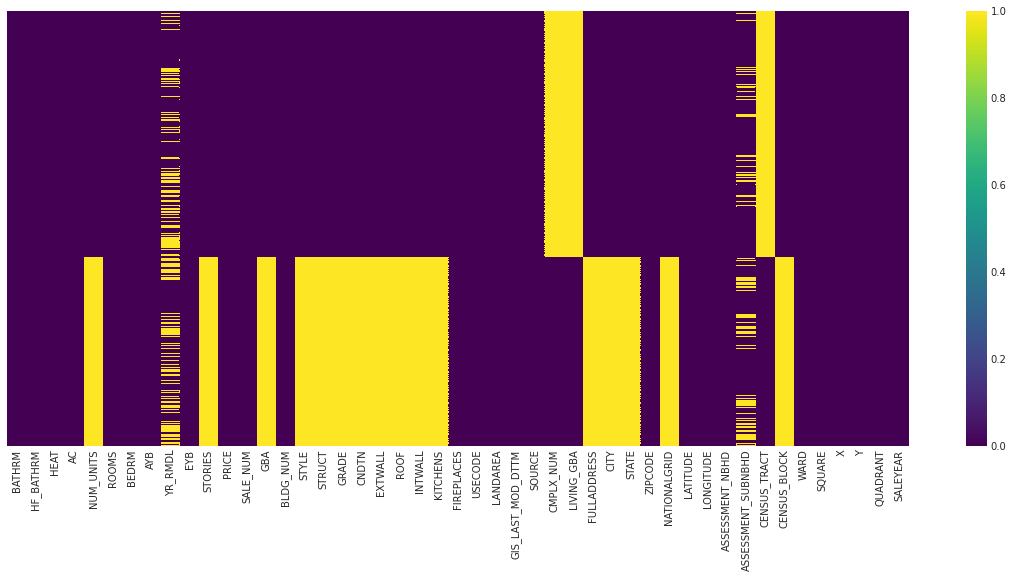

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
sns.heatmap(df_2010_1.isnull(), yticklabels=False,cmap='viridis')
plt.show()

In [ ]:
#drop large missing value : CMPLX_NUM, LIVING_GBA, CENSUS_TRACT
df_clean_1 = df_2010_1.drop(['CMPLX_NUM','LIVING_GBA','CENSUS_TRACT'],axis=1)

In [ ]:
df_clean_1.shape

(41650, 44)

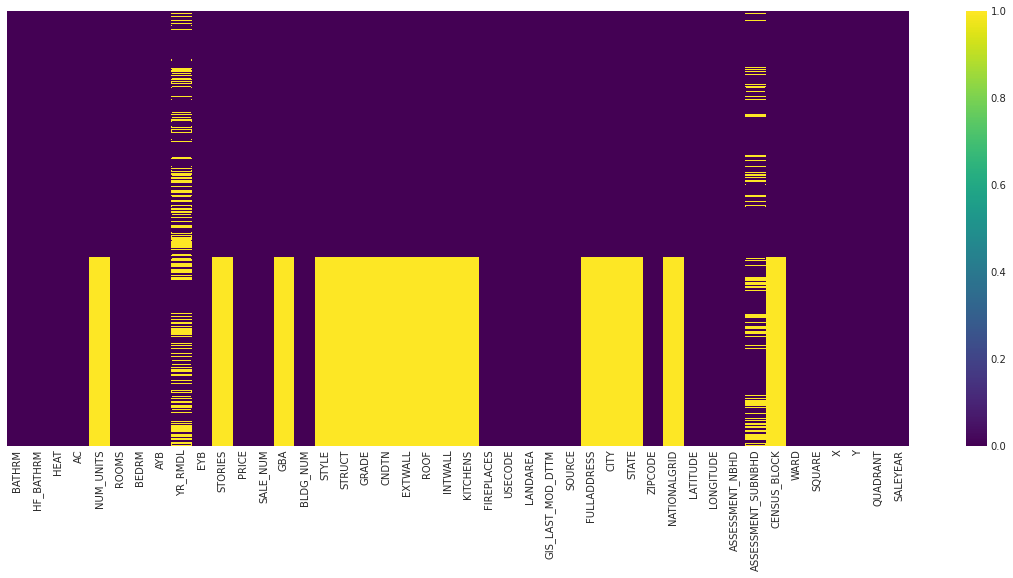

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
sns.heatmap(df_clean_1.isnull(), yticklabels=False,cmap='viridis')
plt.show()

Since ASSESSMENT_NBHD has also high cardinality, we will drop it next.

The YR_RMDL features seems too important to drop. Intuitively, whether the properties have been remodeled or not will affect the price. We decide to do feature engineering by converting the YR_RMDL to boolean (Y/N). Y means the property has been remodeled and vice versa

In [ ]:
#drop ASSESSMENT_NBHD
df_clean_2 = df_clean_1.drop(['ASSESSMENT_SUBNBHD'],axis=1)

In [ ]:
df_clean_2.shape

(41650, 43)

In [ ]:
#feature engineering YR_RMDL
df_clean_3 = df_clean_2.copy()
df_clean_3['RMDL'] = np.where(df_clean_2['YR_RMDL'].isna(),0,1)
df_clean_3 = df_clean_3.drop('YR_RMDL',axis=1)

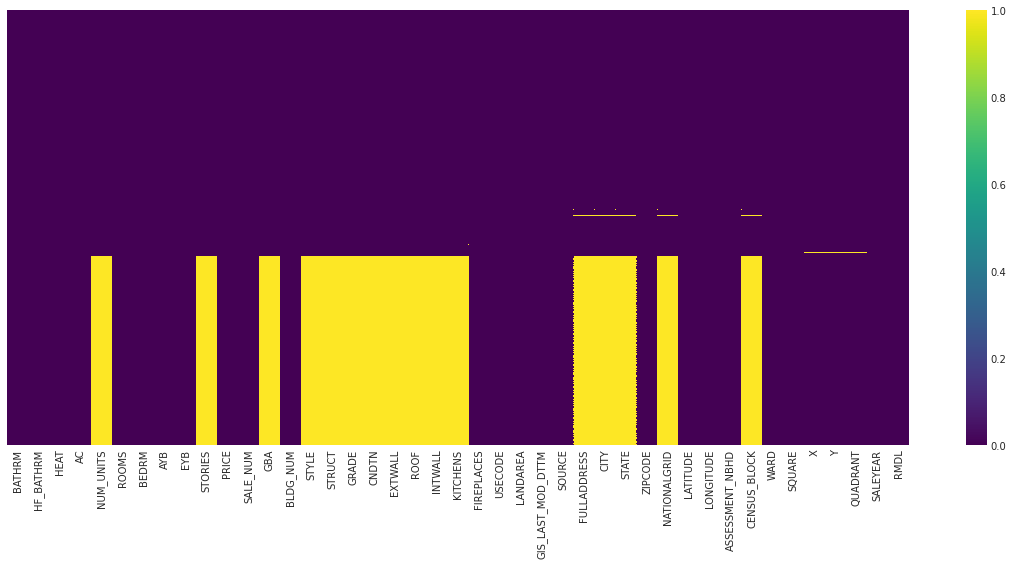

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
sns.heatmap(df_clean_3.isnull(), yticklabels=False,cmap='viridis')
plt.show()

Dropping features :
- FULLADDRESS,NATIONAL GRID, and CENSUS_BLOCK because of high cardinality
- CITY, STATE because they only contain single value (Washington, DC)
- X, Y due to same value with LONGITUDE and LATITUDE
- QUADRANT, because location is already represented by too many features. We also consider to drop other location features in the next step

In [ ]:
df_clean_4 = df_clean_3.drop(['FULLADDRESS','NATIONALGRID','CENSUS_BLOCK','CITY','STATE','X','Y','QUADRANT'],axis=1)

In [ ]:
df_clean_4.shape

(41650, 35)

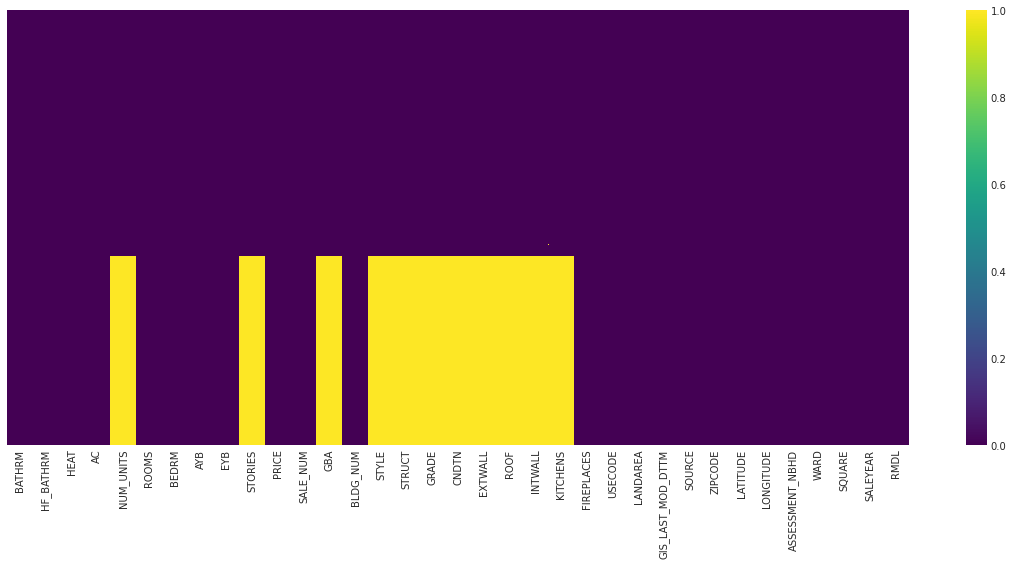

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
sns.heatmap(df_clean_4.isnull(), yticklabels=False,cmap='viridis')
plt.show()

Drop all records with missing values

In [ ]:
df_clean_5 = df_clean_4.dropna()

In [ ]:
df_clean_5.shape

(23527, 35)

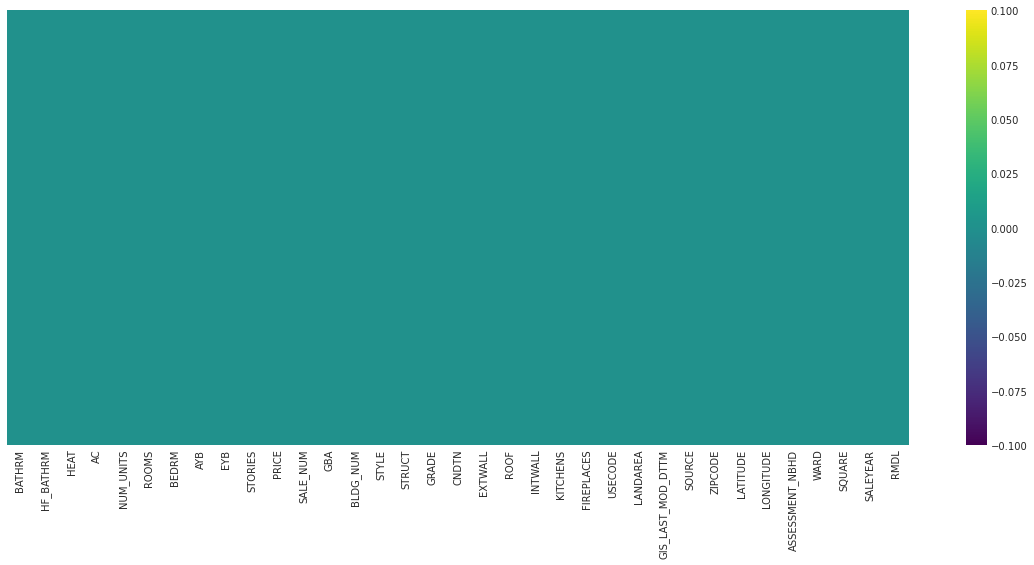

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
sns.heatmap(df_clean_5.isnull(), yticklabels=False,cmap='viridis')
plt.show()

### 5. UNRELATED COLUMNS

some features do not related to the properties (update version date and source data)

In [ ]:
df_clean_6 = df_clean_5.drop(['GIS_LAST_MOD_DTTM','SOURCE'],axis=1)

### 6. SIMILAR VALUES

- STORIES has similar values with STYLE. We keep STYLE since STORIES has many outliers due to mistyping.
- Location is represented by too many features. We want to keep one to be used as the feature.
  - WARD : keep
  - ZIPCODE, ASSESSMENT_NBHD, SQUARE : high cardinality
  - LONGLAT : 

In [ ]:
df_clean_7 = df_clean_6.drop(['STORIES','ZIPCODE','ASSESSMENT_NBHD','SQUARE','LONGITUDE','LATITUDE'],axis=1)

In [ ]:
df_clean_7.shape

(23527, 27)

### 7. OUTLIERS

In [ ]:
df_clean_7['AC'].value_counts()

Y    19450
N     4070
0        7
Name: AC, dtype: int64

In [ ]:
df_clean_7['HEAT'].value_counts()

Forced Air        11574
Hot Water Rad      6867
Warm Cool          4513
Ht Pump             442
Water Base Brd       41
Wall Furnace         26
Elec Base Brd        19
Air-Oil              12
Electric Rad         11
Gravity Furnac        9
Evp Cool              5
Ind Unit              3
No Data               3
Air Exchng            2
Name: HEAT, dtype: int64

- AC : Convert to 1, 0
- HEAT : Delete no data

In [ ]:
df_clean_8 = df_clean_7.copy()
df_clean_8['AC'] = np.where(df_clean_7['AC']=='Y',1,0)

df_clean_8 = df_clean_7[df_clean_7['HEAT']!='No Data']

In [ ]:
df_clean_8.shape

(23524, 27)

### 8. MULTICOLLINEARITY

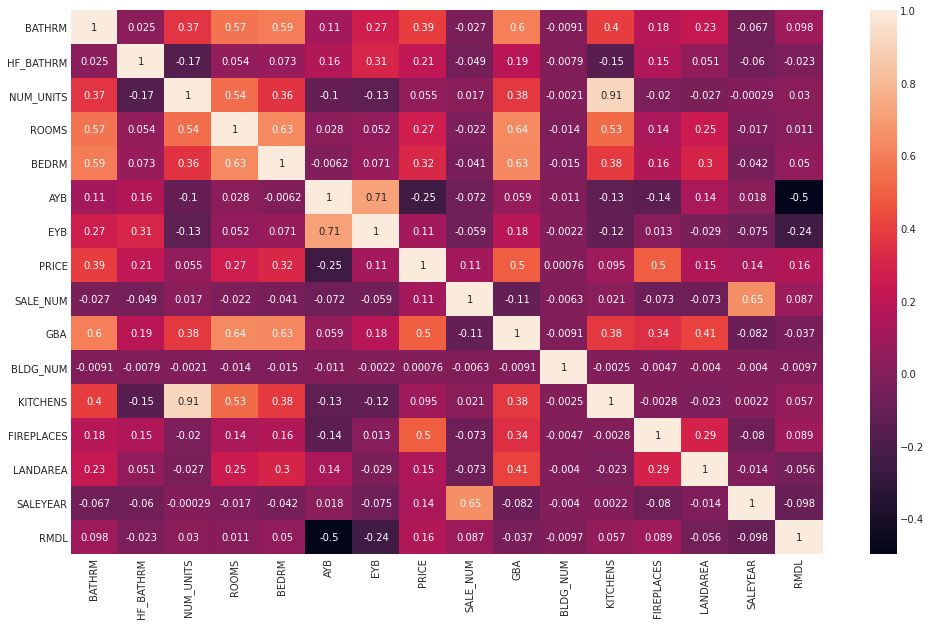

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df_clean_8.corr(), annot=True)
plt.show()

Some multicollinearity occurs between :
  - ROOMS vs (BEDRM, KITCHENS, BATHRM)
  - SALENUM vs SALEYEAR

In [ ]:
df_clean_9 = df_clean_8.drop(['ROOMS','SALE_NUM'],axis=1)

In [ ]:
df_clean_9.shape

(23524, 25)

### 9. ENCODING

In [63]:
!pip install category_encoders

     |████████████████████████████████| 81kB 3.6MB/s 


In [65]:
import category_encoders as ce

In [66]:
ordinal_mapping = [{'col':'CNDTN','mapping':{'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5,'Excellent':6}}]
ordinal_encoder = ce.OrdinalEncoder(cols ='CNDTN',mapping = ordinal_mapping) 
df_clean_10 = ordinal_encoder.fit_transform(df_clean_9)                                                

In [67]:
df_clean_10.head()

,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,BEDRM,AYB,EYB,PRICE,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,WARD,SALEYEAR,RMDL
7,3,1,Hot Water Rad,Y,2,4,1906.0,1972,1050000.0,2401.0,1,3 Story,Row Inside,Very Good,3,Common Brick,Metal- Sms,Hardwood,2,1,24,1627,Ward 2,2011.0,1
14,3,1,Warm Cool,Y,2,3,1917.0,1967,1325000.0,2692.0,1,2 Story,Row Inside,Above Average,5,Stucco,Metal- Sms,Hardwood,2,1,24,1815,Ward 2,2011.0,1
16,3,1,Warm Cool,Y,1,3,1908.0,1967,1240000.0,1662.0,1,2 Story,Row Inside,Above Average,5,Common Brick,Metal- Sms,Hardwood,1,0,11,1424,Ward 2,2010.0,1
23,2,1,Forced Air,Y,1,3,1880.0,1984,1065000.0,1600.0,1,2 Story,Semi-Detached,Above Average,5,Common Brick,Built Up,Hardwood,1,1,13,2090,Ward 2,2012.0,1
24,2,1,Hot Water Rad,Y,1,3,1880.0,1967,1100000.0,1958.0,1,2 Story,Single,Above Average,4,Common Brick,Built Up,Hardwood,1,2,12,2090,Ward 2,2012.0,1


In [68]:
df_clean_10.shape

(23524, 25)

In [ ]:
from google.colab import files
df_clean_9.to_csv('df_clean_10.csv',index=False)
files.download('df_clean_10.csv')